In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import pathlib
import matplotlib.pyplot as plt
from operator import attrgetter
from compounding import saving_summary, compound
from more_itertools import sliding_window, take
from itertools import chain
from operator import attrgetter
from statistics import mean

In [2]:
def read_jsonfile(path: pathlib.Path):
    with open(path, "r") as file:
        obj = json.load(file)
    return obj

In [34]:
path = pathlib.Path(f'../data/monthly-returns.json')
returns = read_jsonfile(path)

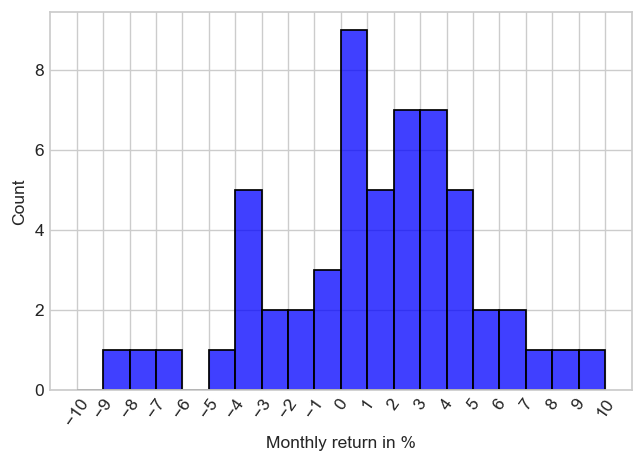

In [54]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(dpi = 125)
sns.histplot(x=np.array(returns['values']) * 100, color="blue", bins=np.arange(-10, 10.01, 1), ax=ax)
plt.xticks(np.arange(-10, 10.01, 1), rotation=55);
plt.xlabel('Monthly return in %');

In [4]:
periods = 120
saving_rate = 5_000
path = pathlib.Path(f'../data/realized-paths-{periods}.json')
realized_paths = read_jsonfile(path)

In [5]:
sampled_returns = list(map(compound, realized_paths.values()))
mean_returns = np.mean(sampled_returns)
percentiles = [np.quantile(sampled_returns, q) for q in np.arange(0, 1.001, 0.01)]

In [6]:
def moving_average(arr: list[float], size: int) -> list[float]:
    windows = sliding_window(iterable=arr, n=size)
    ma = chain(take(size-1, arr), map(mean, windows))
    return list(ma)

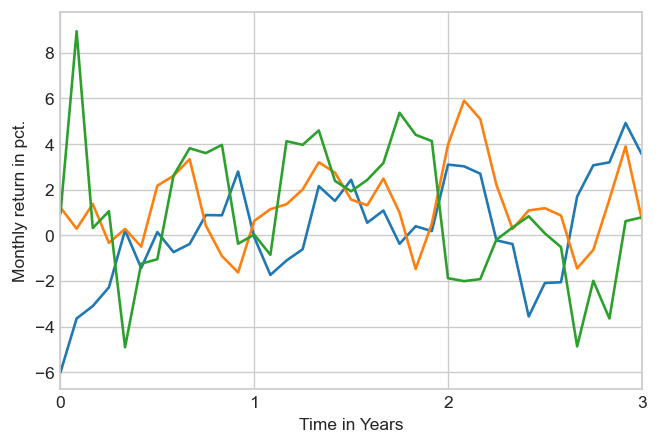

In [7]:
ma_size = 3
n_paths = 3
n_years = 3

fig, ax = plt.subplots(dpi=125)
for i in range(n_paths):
    path = realized_paths[str(i)]
    ma = moving_average(path, ma_size)
    ma = pd.Series(ma, index=np.arange(len(ma)) / 12).multiply(100)
    ax.plot(ma)
ax.set_xlim(0,n_years);
ax.set_xticks(np.arange(n_years+1));
ax.set_xlabel('Time in Years')
ax.set_ylabel('Monthly return in pct.');

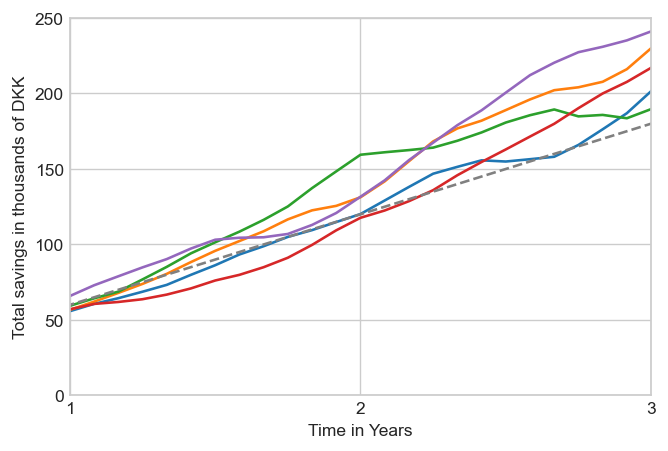

In [8]:
ma_size = 3
n_paths = 5
n_years = 3
passive = np.arange(periods+1) * saving_rate
years = np.arange(periods+1) / 12

fig, ax = plt.subplots(dpi=125)
for i in range(n_paths):
    path = realized_paths[str(i)]
    saving = saving_summary(path, saving=saving_rate)
    saving = list(map(attrgetter('total'), saving))
    ma = moving_average(saving, ma_size)
    ma = pd.Series(ma, index=years).divide(1_000)
    ax.plot(ma)
ax.set_ylim(0, 250);
ax.set_xlim(1,n_years);
ax.plot(pd.Series(passive, index=years).divide(1_000), linestyle = "--", color = "grey")
ax.set_xlabel('Time in Years')
ax.set_ylabel('Total savings in thousands of DKK');
ax.set_xticks(np.arange(1, n_years+1));

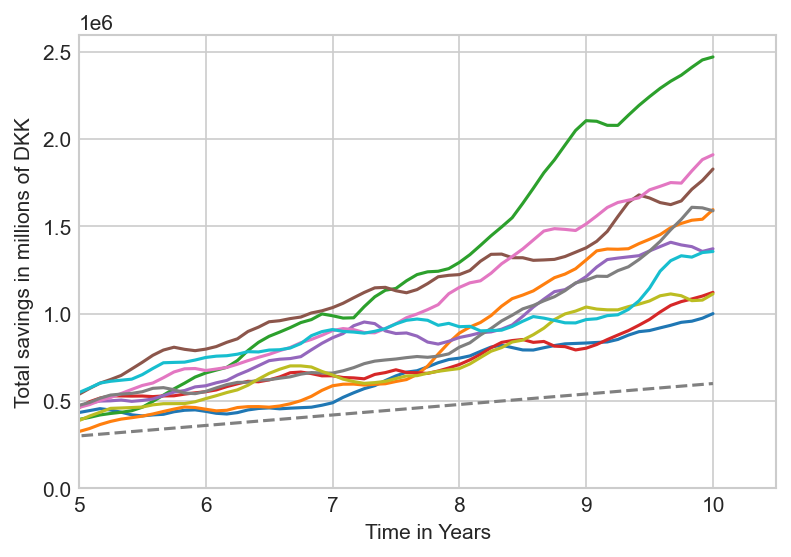

In [9]:
ma_size = 3
n_paths = 10
passive = np.arange(periods+1) * saving_rate
years = np.arange(periods+1) / 12

fig, ax = plt.subplots(dpi=150)
for i in range(n_paths):
    path = realized_paths[str(i)]
    saving = saving_summary(path, saving=saving_rate)
    saving = list(map(attrgetter('total'), saving))
    ma = moving_average(saving, ma_size)
    ma = pd.Series(ma, index=years)
    ax.plot(ma)
ax.set_ylim(0);
ax.set_xlim(5);
ax.plot(pd.Series(passive, index=years), linestyle = "--", color = "grey")
ax.set_xlabel('Time in Years')
ax.set_ylabel('Total savings in millions of DKK');

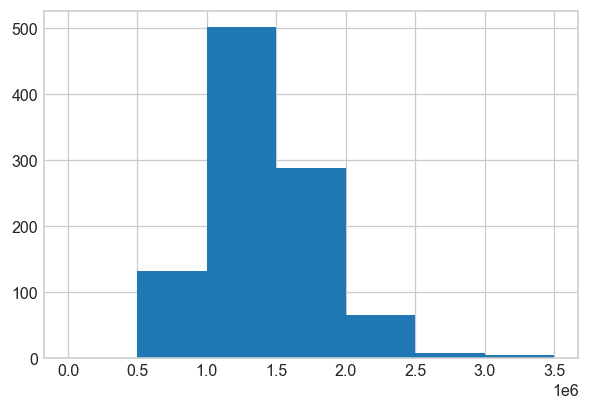

In [31]:
eps = 0.001
fig, ax = plt.subplots(dpi = 115)
ax.hist(sampled_returns, bins=np.arange(0,3.5+eps, 0.5) * 10**6);

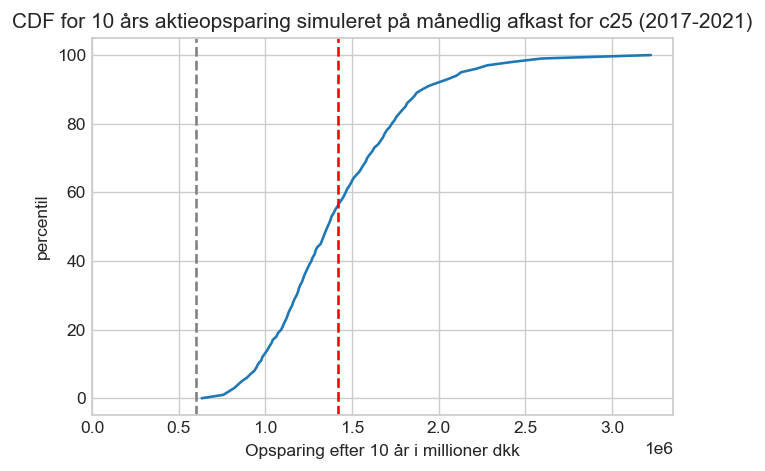

In [11]:
fig, ax = plt.subplots(dpi = 125)
ax.plot(percentiles, range(len(percentiles)))
ax.set(ylabel = "percentil")
ax.set(xlabel = f"Opsparing efter {periods // 12} år i millioner dkk")
ax.set(title  = f"CDF for {periods // 12} års aktieopsparing simuleret på månedlig afkast for c25 (2017-2021)")
ax.axvline(mean_returns, linestyle = "--", color = "red")
ax.axvline(periods * saving_rate, linestyle = "--", color = "grey")
ax.set_xlim(0)
plt.show()